<a href="https://colab.research.google.com/github/ghost331/Recurrent-Neural-Network/blob/main/Covid_19_Analysis_using_RNN_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Data: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
country = "India"

In [ ]:
#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

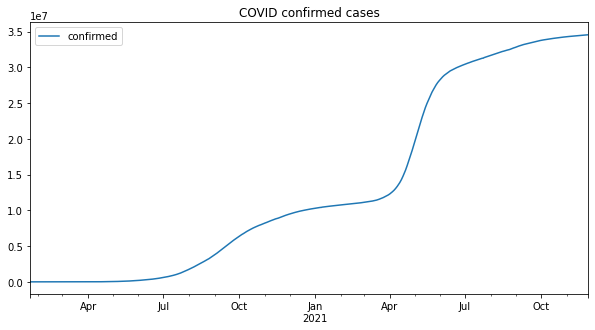

In [ ]:
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')
df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")



In [ ]:
df_confirmed_country.tail(10)

,confirmed
2021-11-18,34489623
2021-11-19,34499925
2021-11-20,34510413
2021-11-21,34518901
2021-11-22,34526480
2021-11-23,34535763
2021-11-24,34544882
2021-11-25,34555431
2021-11-26,34563749
2021-11-27,34572523


In [ ]:
print("Total days in the dataset", len(df_confirmed_country))

Total days in the dataset 676


In [ ]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14


In [ ]:

train=df_confirmed_country.iloc[300:x]
test = df_confirmed_country.iloc[x:]

In [ ]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 


MinMaxScaler()

In [ ]:
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)


In [ ]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)

In [ ]:
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 660
print("Total number of samples in the generated data = ", len(train_generator)) #653  with seq_size=7


Total number of samples in the original training data =  362
Total number of samples in the generated data =  355


In [ ]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)

In [ ]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]


Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation


In [ ]:
#Define Model 
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
print('Train...')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:

history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=30, steps_per_epoch=10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
10/10 [==============================] - 3s 56ms/step - loss: 0.4671 - val_loss: 0.4472
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 0.1177 - val_loss: 2.5830e-04
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0385 - val_loss: 0.0032
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0167 - val_loss: 0.1395
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0287 - val_loss: 0.0444
Epoch 6/30
10/10 [==============================] - 0s 17ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 7/30
10/10 [==============================] - 0s 19ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 8/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0117
Epoch 10/30
10/10 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 4.6384e-04
E

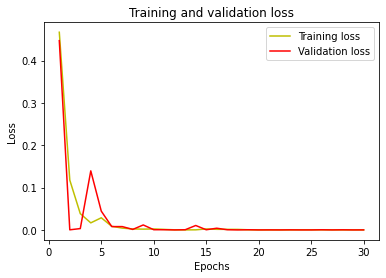

In [ ]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape


In [ ]:
## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

In [ ]:
#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [ ]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

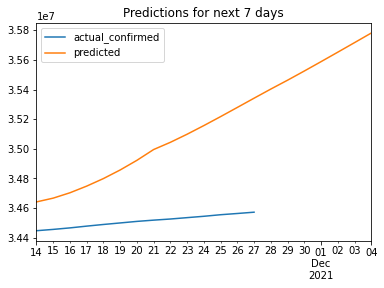

In [ ]:
df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")
